In [26]:
import configparser
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

config = configparser.ConfigParser() 
#read the database configuration which is located in a .ini file
config.read('./config_file.ini') 
HOST = config['DATABASE']['HOST']
DBS = config['DATABASE']['dataBase'].split(',')
URLS = config['DATABASE']['urls'].split(',')
user = config['DATABASE']['user']
passwd = config['DATABASE']['passwd']

In [13]:
# Information related to the websites (Name and URI)
web_pages = dict(zip(DBS,URLS))

In [14]:
def define_query_dbs_NOBP(searching_tags, type = 'accepted'):
    """ Function for creating the query to retrieve  the useful posts from  any database besides STO not 
        taking into account the scores neither if they discuss or not best practices

    Args:
        tag (str): tag that describe which keywords are going to be used in the query
        type (str, optional): accepted/best. Defaults to 'accepted'.

    Returns:
        query_sto (str): query that will be used to retrieve information from any database besides STO (Ignoring scores and discussion of BP)
    """
    if type == 'accepted':
    
        query_dbs = (
        "select  aux.id  QID, aux.AcceptedAnswerId, aux.Title Qtitle, aux.Body QBody, aux.Score QScore, aux.Tags QTags, aux.CreationDate QCreatDate, "
        "p.id  AID,  p.ParentId, p.Body ABody, p.Score AScore, p.Tags ATags, p.CreationDate ACreatDate "
        "from Posts p join "
        "(select * "
        "from Posts pf "
        "where "
        f"MATCH (pf.Tags)  AGAINST ('{searching_tags}' IN BOOLEAN MODE)"
        "and pf.AcceptedAnswerId  is not NULL "
        "and pf.PostTypeId = 1) as aux "
        "on aux.AcceptedAnswerId  = p.Id"
        )

            
    elif type == 'best':
        query_dbs = (
        "SELECT infoQuestions.* FROM "
        "(SELECT  aux.id  QID, aux.AcceptedAnswerId, aux.Title Qtitle, aux.Body QBody, aux.Score QScore, aux.Tags QTags, aux.CreationDate QCreatDate, "
        "p.id  AID,  p.ParentId, p.Body ABody, p.Score AScore, p.Tags ATags, p.CreationDate ACreatDate "
        "FROM Posts p JOIN "
        "(SELECT * "
        "FROM Posts pf "
        "WHERE "
        f"MATCH (pf.Tags)  AGAINST ('{searching_tags}' IN BOOLEAN MODE) "
        "and pf.AcceptedAnswerId  is not NULL "
        "and pf.PostTypeId = 1) as aux "
        "ON aux.Id  = p.ParentId) as infoQuestions, "
        "(SELECT QID, max(p.Score) MAXScore "
        "FROM Posts p JOIN "
        "(SELECT pf.AcceptedAnswerId, pf.Id QID  "
        "FROM Posts pf "
        "WHERE "
        f"MATCH (pf.Tags)  AGAINST ('{searching_tags}' IN BOOLEAN MODE) "
        "and pf.AcceptedAnswerId  is not NULL "
        "and pf.PostTypeId = 1 ) as aux "
        "ON aux.QID  = p.ParentId " 
        "GROUP BY QID) as maxScore "
        "WHERE infoQuestions.QID = maxScore.QID AND infoQuestions.AScore =  maxScore.MAXScore"
        )
            
    else:
        print('No query')
        query_dbs = None
    
    return query_dbs

In [15]:
def define_query_dbs_nscore(searching_tags, type = 'accepted'):
    """ Function for creating the query to retrieve  the useful posts from  any database besides STO not 
        taking into account the scores

    Args:
        tag (str): tag that describe which keywords are going to be used in the query
        type (str, optional): accepted/best. Defaults to 'accepted'.

    Returns:
        query_sto (str): query that will be used to retrieve information from any database besides STO (Ignoring scores)
    """

    if type == 'accepted':
    
        query_dbs = (
        "select  aux.id  QID, aux.AcceptedAnswerId, aux.Title Qtitle, aux.Body QBody, aux.Score QScore, aux.Tags QTags, aux.CreationDate QCreatDate, "
        "p.id  AID,  p.ParentId, p.Body ABody, p.Score AScore, p.Tags ATags, p.CreationDate ACreatDate "
        "from Posts p join "
        "(select * "
        "from Posts pf "
        "where MATCH (pf.Body,pf.Title)  AGAINST ('\"best practice\" \"best practices\" \"good practice\"  \"good practices\"' IN BOOLEAN MODE) "
        f"and MATCH (pf.Tags)  AGAINST ('{searching_tags}' IN BOOLEAN MODE)"
        "and pf.AcceptedAnswerId  is not NULL "
        "and pf.PostTypeId = 1) as aux "
        "on aux.AcceptedAnswerId  = p.Id"
            )
       
    elif type == 'best':
        
        query_dbs = (
        "SELECT infoQuestions.* FROM "
        "(SELECT  aux.id  QID, aux.AcceptedAnswerId, aux.Title Qtitle, aux.Body QBody, aux.Score QScore, aux.Tags QTags, aux.CreationDate QCreatDate, "
        "p.id  AID,  p.ParentId, p.Body ABody, p.Score AScore, p.Tags ATags, p.CreationDate ACreatDate "
        "FROM Posts p JOIN "
        "(SELECT * "
        "FROM Posts pf "
        "WHERE MATCH (pf.Body,pf.Title)  AGAINST ('\"best practice\" \"best practices\" \"good practice\" \"good practices\" ' IN BOOLEAN MODE) "
        "and pf.AcceptedAnswerId  is not NULL "
        "and pf.PostTypeId = 1) as aux "
        "ON aux.Id  = p.ParentId) as infoQuestions, "
        "(SELECT QID, max(p.Score) MAXScore "
        "FROM Posts p JOIN "
        "(SELECT pf.AcceptedAnswerId, pf.Id QID  "
        "FROM Posts pf "
        "WHERE MATCH (pf.Body,pf.Title)  AGAINST ('\"best practice\" \"best practices\" \"good practice\" \"good practices\"' IN BOOLEAN MODE) "
        f"and MATCH (pf.Tags)  AGAINST ('{searching_tags}' IN BOOLEAN MODE) "
        "and pf.AcceptedAnswerId  is not NULL "
        "and pf.PostTypeId = 1 ) as aux "
        "ON aux.QID  = p.ParentId " 
        "GROUP BY QID) as maxScore "
        "WHERE infoQuestions.QID = maxScore.QID AND infoQuestions.AScore =  maxScore.MAXScore"
        )
            
    else:
        print('No query')
        query_dbs = None
    
    return query_dbs

In [16]:
def define_STO_query_NOBP( tag, type = 'accepted'):
    """ Function for creating the query to retrieve  the useful posts from StackOverflow  not 
        taking into account the scores neither if they discuss or not best practices

    Args:
        tag (str): tag that describe which keywords are going to be used in the query, this defines a specific database, 
        due to the size of STO partial tables were created.
        type (str, optional): accepted/best. Defaults to 'accepted'.

    Returns:
        query_sto (str): query that will be used to retrieve information from STO (ignoring scores and discussion of BP))
    """

    databases_sto = {'\"machine-learning\"': 'PostsQuestionsFilteredNoScore'}
    selected_db = databases_sto[tag]
    
    if type == 'accepted':
    
        query_sto = (
        "select  aux.id  QID, aux.AcceptedAnswerId, aux.Title Qtitle, aux.Body QBody, aux.Score QScore, aux.Tags QTags, aux.CreationDate QCreatDate, "
        "p.id  AID,  p.ParentId, p.Body ABody, p.Score AScore, p.Tags ATags, p.CreationDate ACreatDate "
        "from PostsAnswersFilteredNoScoreML p join "
        "(select * "
        f"from {selected_db} pf "
        "where "
        "pf.AcceptedAnswerId  is not NULL) as aux "
        "on aux.AcceptedAnswerId  = p.Id"
        )
            
    elif type == 'best':
        
        query_sto = (
        "SELECT infoQuestions.* FROM "
        "(SELECT  aux.id  QID, aux.AcceptedAnswerId, aux.Title Qtitle, aux.Body QBody, aux.Score QScore, aux.Tags QTags, aux.CreationDate QCreatDate, "
        "p.id  AID,  p.ParentId, p.Body ABody, p.Score AScore, p.Tags ATags, p.CreationDate ACreatDate "
        "FROM PostsAnswersFilteredNoScoreML p JOIN "
        "(SELECT * "
        f"FROM {selected_db} pf "
        "WHERE  "
        "pf.AcceptedAnswerId  is not NULL) as aux "
        "ON aux.Id  = p.ParentId) as infoQuestions, "
        "(SELECT QID, max(p.Score) MAXScore "
        "FROM PostsAnswersFilteredNoScoreML p JOIN "
        "(SELECT pf.AcceptedAnswerId, pf.Id QID " 
        f"FROM {selected_db} pf "
        "WHERE "
        " pf.AcceptedAnswerId  is not NULL) as aux "
        "ON aux.QID  = p.ParentId "
        "GROUP BY QID) as maxScore "
        "WHERE infoQuestions.QID = maxScore.QID AND infoQuestions.AScore =  maxScore.MAXScore"
        )
            
    else:
        print('NO QUERY')
        query_sto = None

    return query_sto

In [17]:
def define_STO_query_nscore( tag, type = 'accepted'):
    """ Function for creating the query to retrieve  the useful posts from StackOverflow  not 
        taking into account the scores

    Args:
        tag (str): tag that describe which keywords are going to be used in the query, this defines a specific database, 
        due to the size of STO partial tables were created.
        type (str, optional): accepted/best. Defaults to 'accepted'.

    Returns:
        query_sto (str): query that will be used to retrieve information from STO (ignoring scores)
    """

    databases_sto = {'\"machine-learning\"': 'PostsQuestionsFilteredNoScore'}
    selected_db = databases_sto[tag]
    
    if type == 'accepted':
    
        query_sto = (
        "select  aux.id  QID, aux.AcceptedAnswerId, aux.Title Qtitle, aux.Body QBody, aux.Score QScore, aux.Tags QTags, aux.CreationDate QCreatDate, "
        "p.id  AID,  p.ParentId, p.Body ABody, p.Score AScore, p.Tags ATags, p.CreationDate ACreatDate "
        "from PostsAnswersFilteredNoScoreML p join "
        "(select * "
        f"from {selected_db} pf "
        "where MATCH (pf.Body,pf.Title)  AGAINST ('\"best practice\" \"best practices\" \"good practice\"  \"good practices\"' IN BOOLEAN MODE) "
        "and pf.AcceptedAnswerId  is not NULL) as aux "
        "on aux.AcceptedAnswerId  = p.Id"
        )
            
    elif type == 'best':
        
        query_sto = (
        "SELECT infoQuestions.* FROM "
        "(SELECT  aux.id  QID, aux.AcceptedAnswerId, aux.Title Qtitle, aux.Body QBody, aux.Score QScore, aux.Tags QTags, aux.CreationDate QCreatDate, "
        "p.id  AID,  p.ParentId, p.Body ABody, p.Score AScore, p.Tags ATags, p.CreationDate ACreatDate "
        "FROM PostsAnswersFilteredNoScoreML p JOIN "
        "(SELECT * "
        f"FROM {selected_db} pf "
        "WHERE MATCH (pf.Body,pf.Title)  AGAINST ('\"best practice\"  \"best practices\" \"good practice\"  \"good practices\"' IN BOOLEAN MODE) "
        "and pf.AcceptedAnswerId  is not NULL) as aux "
        "ON aux.Id  = p.ParentId) as infoQuestions, "
        "(SELECT QID, max(p.Score) MAXScore "
        "FROM PostsAnswersFilteredNoScoreML p JOIN "
        "(SELECT pf.AcceptedAnswerId, pf.Id QID " 
        f"FROM {selected_db} pf "
        "WHERE MATCH (pf.Body,pf.Title)  AGAINST ('\"best practice\" \"best practices\" \"good practice\" \"good practices\"' IN BOOLEAN MODE) "
        " and pf.AcceptedAnswerId  is not NULL) as aux "
        "ON aux.QID  = p.ParentId "
        "GROUP BY QID) as maxScore "
        "WHERE infoQuestions.QID = maxScore.QID AND infoQuestions.AScore =  maxScore.MAXScore"
        )
            
    else:
        print('NO QUERY')
        query_sto = None

    return query_sto

In [18]:
def get_answers(web_pages, query,query2='', ans_type='best', verbose = True):
    """Function that is used to obtain all the best voted or accepted answers for a question in  the 14 STE sites

    Args:
        web_pages (list): list of tuples, (name database, url)
        query (str): Query to retrieve information that is not used in StackOverflow.
        query2 (str, optional): StackOverflow query (due to in STO partial tables were created because of the sizeos STO). Defaults to ''.
        ans_type (str, optional): string that allow to differentiate in the data between accepted vs most voted. Defaults to 'best'.
        verbose (bool, optional): Flag for printing details of the process. Defaults to True.

    Returns:
        DataFrame: DataFrame that contains all the possible relevant posts for the study 
    """
        
    list_dfs = []
    for db, web_site in web_pages.items():
        sqlEngine  = create_engine(f'mysql+pymysql://{user}:{passwd}@{HOST}/{db}', pool_recycle=3600)
        dbConnection = sqlEngine.connect()
        
        if 'https://stackoverflow.com' not in web_site:
            if verbose:
                print(db)
            df2 = pd.read_sql(query, dbConnection)
            
            if verbose:
                print(df2.shape)

        else:
            if verbose:
                print(db)
            df2 = pd.read_sql(query2, dbConnection)
            
            if verbose:
                print(df2.shape) 

        df2['base_url'] = web_pages[db]
        df2['type'] = ans_type
        list_dfs.append(df2)

        dbConnection.close()
    result = pd.concat(list_dfs)
    return result

In [19]:
    
def cleaning_answers(df_best, df_accepted, verbose = True):
    """Functions for cleaning questions and answers duplicates.

    Args:
        df_best (DataFrame): DataFrame with the most voted answer per selected question
        df_accepted (DataFrame): DataFrame with the accepted answer per selected question
        verbose (bool, optional): Variable that control the print statements, in order to give information of the size of the datafrmaes. Defaults to True.

    Returns:
        whole_posts (DataFrame): complete set of pairs including duplicates
        question_unique (DataFrames): Dataframe of the questions associated to each unique answer
        answers_positive (DataFrame): Datframe of unique answers
    """
    
    #set urls for question and answers
    df_accepted['url_question'] = df_accepted['base_url'] + df_accepted['QID'].apply(str)
    df_accepted['url_AcceptedAns'] = df_accepted['base_url'] + df_accepted['AcceptedAnswerId'].apply(str)
    df_best['url_question'] = df_best['base_url'] + df_best['QID'].apply(str)
    df_best['url_AcceptedAns'] = df_best['base_url'] + df_best['AcceptedAnswerId'].apply(str)

    all_posts = pd.concat([df_accepted, df_best])
    
    if verbose:
        print('The total rows are (all posts)', all_posts.shape)
    
    # delete answers that are both the best answer and the accepted answer (duplicates)
    non_duplicated_posts = all_posts.drop_duplicates(subset =['QID', 'AcceptedAnswerId', 'Qtitle', 'QBody', 'QScore', 'QTags',
        'QCreatDate', 'AID', 'ParentId', 'ABody', 'AScore', 'ATags',
        'ACreatDate', 'base_url'], keep='first')
    
    if verbose:
        print('The total rows after deleting duplicates are (all posts)', non_duplicated_posts.shape)
        
    # split info related to questions
    questions_posts= non_duplicated_posts[['QID', 'AcceptedAnswerId', 'Qtitle', 'QBody', 'QScore', 'QTags', 'url_question']]
    # split info related to answers
    answers_posts= non_duplicated_posts[['AID','ParentId', 'AcceptedAnswerId', 'ABody', 'AScore', 'ATags', 'url_AcceptedAns','type']]  
    
    
    # retrieve only the data that is related to answers and has a positive score (greater than 0)
    answers_positive = answers_posts.copy()

    if verbose:
        print('The total rows with all scores are (answers)', answers_positive.shape)
    #answers_positive= answers_positive[answers_positive.AScore>0]
    
    if verbose:
        print('The total rows with positive score are (answers)', answers_positive.shape)
    
    question_unique = questions_posts.drop_duplicates(subset =['QID', 'AcceptedAnswerId', 'Qtitle', 'QBody', 'QScore', 'QTags',
       'url_question'], keep='first')
    
    if verbose:
        print('The total unique number of question are (questions)', question_unique.shape)
        
    #whole_posts = non_duplicated_posts[(non_duplicated_posts.AScore>0)]
    whole_posts = non_duplicated_posts

    
    return whole_posts, question_unique, answers_positive
        

In [9]:
# Information. Retrieving information (questions and answers) from the databases ignoring  BP and SCORES 

accepted_question_ml = define_query_dbs_NOBP('\"machine-learning\"', type = 'accepted')
accepted_question_ml_sto = define_STO_query_NOBP( '\"machine-learning\"', type = 'accepted')
all_accepted_NOBP = get_answers(web_pages, accepted_question_ml, accepted_question_ml_sto, "accepted", verbose= False)

best_question_ml = define_query_dbs_NOBP('\"machine-learning\"', type = 'best')
best_question_ml_sto = define_STO_query_NOBP( '\"machine-learning\"', type = 'best')
all_best_answers_NOBP= get_answers(web_pages, best_question_ml, best_question_ml_sto, "best", verbose= False)

_, df_nobp_questions, df_nobp_answers =  cleaning_answers(all_best_answers_NOBP, all_accepted_NOBP, verbose = True)

df_nobp_questions.shape, df_nobp_answers.shape

The total rows are (all posts) (43303, 17)
The total rows after deleting duplicates are (all posts) (23464, 17)
The total rows with all scores are (answers) (23464, 8)
The total rows with positive score are (answers) (23464, 8)
The total unique number of question are (questions) (20965, 7)


((20965, 7), (23464, 8))

In [10]:
# Convert scores into numbers (objects -> numbers)
df_nobp_questions['QScore'] = df_nobp_questions['QScore'].astype('int')
df_nobp_answers['AScore'] = df_nobp_answers['AScore'].astype('int')

In [20]:
# Information. Retrieving information (questions and answers) just ignoring scores

accepted_question_ml = define_query_dbs_nscore('\"machine-learning\"', type = 'accepted')
accepted_question_ml_sto = define_STO_query_nscore( '\"machine-learning\"', type = 'accepted')
original_accepted = get_answers(web_pages, accepted_question_ml, accepted_question_ml_sto, "accepted", verbose= False)

best_question_ml = define_query_dbs_nscore('\"machine-learning\"', type = 'best')
best_question_ml_sto = define_STO_query_nscore( '\"machine-learning\"', type = 'best')
original_best_answers= get_answers(web_pages, best_question_ml, best_question_ml_sto, "best", verbose= False)

_, df_original_questions, df_original_answers =  cleaning_answers(original_best_answers, original_accepted, verbose = True)

df_original_questions.shape, df_original_answers.shape

The total rows are (all posts) (249, 17)
The total rows after deleting duplicates are (all posts) (134, 17)
The total rows with all scores are (answers) (134, 8)
The total rows with positive score are (answers) (134, 8)
The total unique number of question are (questions) (122, 7)


((122, 7), (134, 8))

In [21]:
# Convert scores into numbers (objects -> numbers)
df_original_questions['QScore'] = df_original_questions['QScore'].astype('int')
df_original_answers['AScore'] = df_original_answers['AScore'].astype('int')

### Plots that are/are not in the paper 
* Plots and data related to posts without taking into account BP are not presented in the paper
* Plots (boxplots) and data related to the posts that are just ignoring scores are present in the paper

#### Ignoring BP and scores

In [22]:
df_nobp_questions['QScore'].describe()

count    20965.000000
mean         4.914143
std         16.198002
min         -6.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        862.000000
Name: QScore, dtype: float64

In [23]:
df_nobp_answers['AScore'].describe()

count    23464.000000
mean         5.442380
std         20.562391
min         -7.000000
25%          1.000000
50%          2.000000
75%          4.000000
max       1436.000000
Name: AScore, dtype: float64

#### Just ignoring scores

In [24]:
df_original_questions['QScore'].describe()

count    122.000000
mean       7.327869
std       18.476003
min       -2.000000
25%        1.000000
50%        3.000000
75%        6.000000
max      164.000000
Name: QScore, dtype: float64

In [25]:
df_original_answers['AScore'].describe()

count    134.000000
mean       6.850746
std       15.163028
min        0.000000
25%        1.000000
50%        3.000000
75%        5.000000
max      128.000000
Name: AScore, dtype: float64

#### Plot the distributions of the two samples, side by side (not in paper)

(-2.0, 4.0)

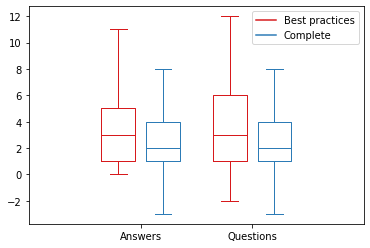

In [40]:
#settiing data 

# Save variables related to ML  post distribution without filtering by score ignoring BP
O_answers = df_nobp_answers['AScore']
O_questions = df_nobp_questions['QScore']
# Save variables with the best practices post distribution without filtering by score
n_answers = df_original_answers['AScore']
n_questions = df_original_questions['QScore']

data_nscores = [ n_answers, n_questions]
data_nobp_nscores= [ O_answers, O_questions]

# Labels on the X axis
ticks = ['Answers', 'Questions']

def box_whisker_color(bp, color):
    
    plt.setp(bp['whiskers'], color= color)
    plt.setp(bp['caps'], color= color)
    plt.setp(bp['boxes'], color= color)
    plt.setp(bp['medians'], color= color)

plt.figure()

# Manualy moving the boxplots, in order to have a group box plot (g1:answers, g2:questions)
plot_nscores = plt.boxplot(data_nscores, positions=np.array(range(len(data_nscores)))*2.0-0.4, widths=0.6, sym='', showfliers=True)
plot_nobp_nscores = plt.boxplot(data_nobp_nscores, positions=np.array(range(len(data_nobp_nscores)))*2.0+0.4, widths=0.6, sym='', showfliers=True)

# Set red color to the best practices ignoring scores and ble color for the complete set ignoring BP and scores
box_whisker_color(plot_nscores, '#D7191C') # colors are from http://colorbrewer2.org/
box_whisker_color(plot_nobp_nscores, '#2C7BB6')

# Defining and plotting the legends 
plt.plot([], c='#D7191C', label='Best practices')
plt.plot([], c='#2C7BB6', label='Complete')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)

# Save the boxplots, uncomment to save it 
#plt.savefig('boxcompare.png')

# plot based on the following answer in STO
# https://stackoverflow.com/questions/16592222/matplotlib-group-boxplots

#### Plot of the scores of the posts, just ignoring the score  

In [29]:
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter

In [51]:
# Extract just the scores of the questions and answers that discuss best practices 
n_answers = df_original_answers[['AScore']].copy()
n_questions = df_original_questions[['QScore']].copy()

n_questions.rename(columns={"QScore": "Score"}, inplace = True)
n_answers.rename(columns={"AScore": "Score"}, inplace = True)

n_questions['boxPlot'] = 'Questions'
n_answers['boxPlot'] = 'Answers'

#Cheking sizes
n_answers.shape, n_questions.shape


In [60]:
#Cheking size after concateeting Q&A
box_plot = pd.concat([n_answers, n_questions])
box_plot.shape

(256, 2)

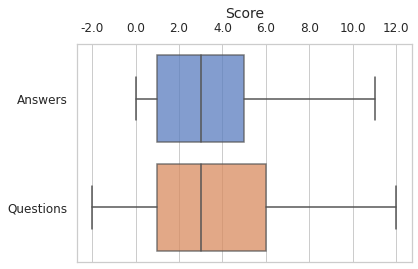

In [61]:
# Set ehite grid as nackground
sns.set(style="whitegrid")

# Plot boxplot for the distributions of dates of the used posts (Unique questions + all answers)
fig = sns.boxplot(y= 'boxPlot', x = 'Score', data = box_plot, showfliers=False, palette="muted", boxprops=dict(alpha=.75))

#moving label and ticks to the top
fig.xaxis.set_label_position('top')
plt.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)

#Setting labels in the plot 
fig.set(ylabel = None)
fig.set_xlabel('Score', fontsize=14)

#Settiing format of 1 float number of the ticks
fig.xaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))

plt.show()